# Ritz method for a beam

**November, 2018**

We want to find a Ritz approximation of the deflection $w$ of a beam under applied
transverse uniform load of intensity $f$ per unit lenght and an end moment $M$.
This is described by the following boundary value problem.

$$
\frac{\mathrm{d}^2}{\mathrm{d}x^2}\left(EI \frac{\mathrm{d}^2w}{\mathrm{d}x^2}\right) = f\, ,\quad
0 < x < L,\quad EI>0\, ,
$$

with

$$
w(0) = w'(0) = 0,\quad
\left(EI \frac{\mathrm{d}^2w}{\mathrm{d}x^2}\right)_{x=L} = M,\quad
\left[\frac{\mathrm{d}}{\mathrm{d}x}\left(EI \frac{\mathrm{d}^2w}{\mathrm{d}x^2}\right)\right]_{x=L} = 0\, .
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

In [2]:
%matplotlib notebook
init_printing()

# Graphics setup
gray = '#757575'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.color"] = gray
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.color"] = gray
plt.rcParams["ytick.color"] = gray
plt.rcParams["axes.labelcolor"] = gray
plt.rcParams["axes.edgecolor"] = gray
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = 4, 3

The exact solution for this problem is

$$w(x) = \left(\frac{2M + fL^2}{4EI}\right)x^2 - \frac{fL}{6EI}x^3 + \frac{f}{24EI}x^4\, .$$

In [3]:
x = symbols('x')
M, EI, f, L, Mb = symbols("M EI f L Mb")
w_exact = (2*M + f*L**2)/(4*EI)*x**2 - f*L/(6*EI)*x**3 + f/(24*EI)*x**4
psi_exact = -(2*M + f*L**2)/(2*EI)*x + f*L*x**2/(2*EI) - f*x**3/(6*EI)
M_exact = f/2*(x - L)**2 + Mb
lamda_exact = f*(L - x)

In [4]:
def plot_expr(expr, x, rango=(0, 1), ax=None, linestyle="solid"):
    """Plot SymPy expressions of a single variable"""
    expr_num = lambdify(x, expr, "numpy")
    x0 = rango[0]
    x1 = rango[1]
    x_num = np.linspace(0, 1, 101)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(x_num, expr_num(x_num), linestyle=linestyle)

## Conventional formulation

We can transform the boundary value problem to

$$\frac{\mathrm{d}^2}{\mathrm{d}x^2}\left(EI\frac{\mathrm{d}^2 u}{\mathrm{d}x^2}\right) = \hat{f}\, ,\quad 0 < x< L$$

with

$$u(0) = u'(0) = EI u''(L) = \left[\frac{\mathrm{d}}{\mathrm{d}x^2}(EI w'')\right]_{x=L} = 0\, ,$$

and

$$u = w - w_0, \hat{f} = f - \frac{\mathrm{d}}{\mathrm{d}x^2}(EI w_0'')$$

where $w_0$ satisfies the boundary conditions. For this case we can chose

$$w_0 = \frac{M x^2}{2EI}\, ,$$

that satisfies the boundary conditions. For this choice, we have $\hat{f} = f$.

The quadratic functional for this problem is

$$J[u] = \int\limits_0^L \left[EI\left(\frac{\mathrm{d}^2 u}{\mathrm{d}x^2}\right)^2 - fu\right]\mathrm{d}x\, ,$$

and the weak problem $B(v, u) = l(v)$, with

$$
B(v, u) = \int\limits_0^L EI\frac{\mathrm{d}^2 v}{\mathrm{d}x^2}\frac{\mathrm{d}^2 u}{\mathrm{d}x^2}\mathrm{d}x\, ,\quad
l(v) = \int\limits_0^L v f\mathrm{d}x\, .
$$

In [5]:
def quad_fun(x, u, M, EI, f, L):
    F = EI/2*diff(u, x, 2)**2 - f*u
    L = integrate(F, (x, 0, L))
    return L
    

In [6]:
def ritz_conventional(x, M, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    u = sum(a[k]*x**(k + 2) for k in range(nterms))
    M, EI, f, L = symbols("M EI f L")
    L = quad_fun(x, u, M, EI, f, L)
    eqs = [L.diff(C) for C in a]
    sol = solve(eqs, a)
    return u.subs(sol)

<IPython.core.display.Javascript object>


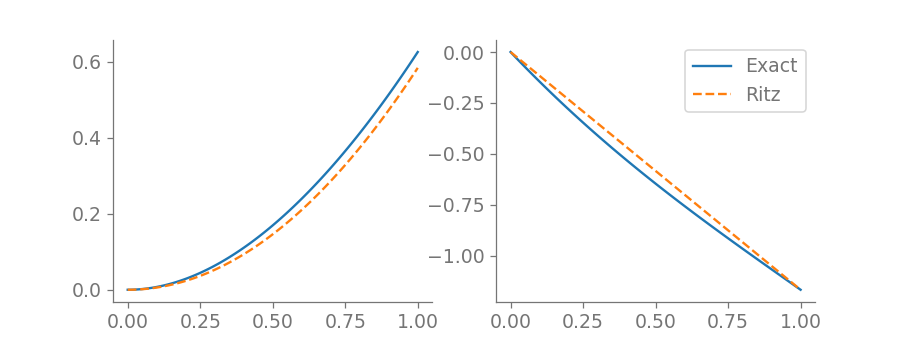

<IPython.core.display.Javascript object>


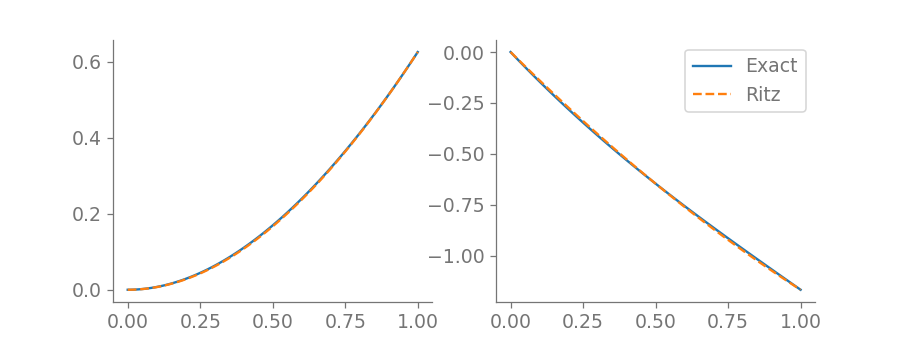

<IPython.core.display.Javascript object>


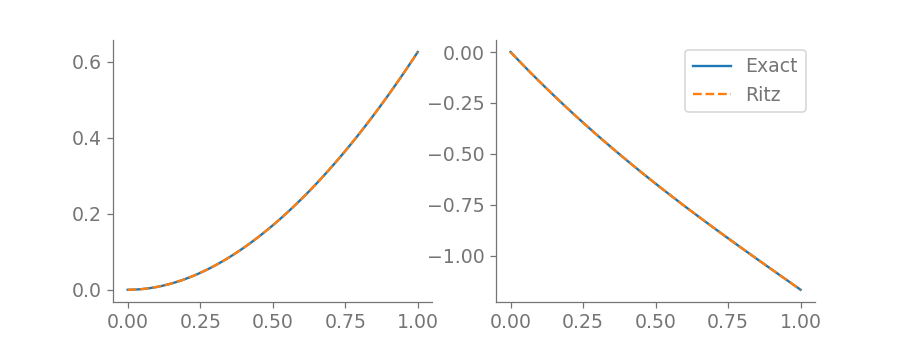

In [7]:
w0 = M*x**2/(2*EI)
subs = {L: 1, EI:1, M:1, f: 1}
errors_conv = []
for nterms in range(1, 4):
    u = ritz_conventional(x, M, EI, f, L, nterms)
    w = u + w0
    err = integrate((w - w_exact)**2, (x, 0, L))
    norm = integrate(w_exact**2, (x, 0, L))
    errors_conv.append(N(sqrt((err/norm).subs(subs))))
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(121)
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    ax = plt.subplot(122)
    plot_expr(psi_exact.subs(subs), x, ax=ax)
    plot_expr(-w.diff(x).subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz"]);

## Lagrange multiplier formulation

We can write the problem as minimizing the functional

$$J(\psi, w) = \int\limits_0^L\left[\frac{EI}{2}\left(\frac{\mathrm{d}^2 w}{\mathrm{d}x^2}\right)^2 -
f w\right]\mathrm{d}x + M\psi(L)\, ,$$

subject to

$$G(\psi, w) \equiv \psi + \frac{\mathrm{d}w}{\mathrm{d}x} = 0\, .$$

The Lagrangian is given by

$$L(\psi, w, \lambda) = \int\limits_0^L\left[\frac{EI}{2}\left(\frac{\mathrm{d}^2 w}{\mathrm{d}x^2}\right)^2 -
f w\right]\mathrm{d}x + \int\limits_0^L \lambda\left(\psi + \frac{\mathrm{d}x}{\mathrm{d}x}\right)\mathrm{d}x + M\psi(L)\, , $$

where $\lambda$ is the Lagrange multiplier, which in this case represents the shear force.

In [8]:
errors_conv

In [9]:
def lagran(x, psi, w, lamda, M, EI, f, L):
    F = EI/2*diff(psi, x)**2 - f*w
    G = lamda*(psi + diff(w, x))
    L = integrate(F, (x, 0, L)) + integrate(G, (x, 0, L)) + M*psi.subs(x, L)
    return L
    

In [10]:
def ritz_multiplier(x, M, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    b = symbols("b0:%i"%(nterms))
    c = symbols("c0:%i"%(nterms))
    var = a + b + c
    psi = sum(a[k]*x**(k + 1) for k in range(nterms))
    w = sum(b[k]*x**(k + 1) for k in range(nterms))
    lamda = sum(c[k]*x**k for k in range(nterms))
    M, EI, f, L = symbols("M EI f L")
    L = lagran(x, psi, w, lamda, M, EI, f, L)
    eqs = [L.diff(C) for C in var]
    sol = solve(eqs, var)
    return w.subs(sol), psi.subs(sol), lamda.subs(sol)

<IPython.core.display.Javascript object>


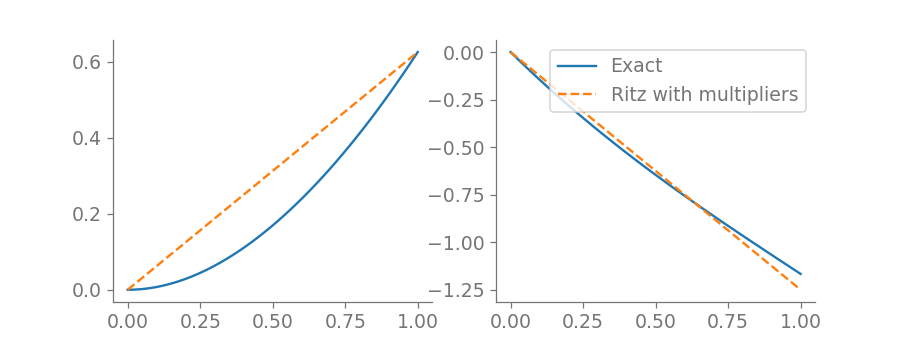

<IPython.core.display.Javascript object>


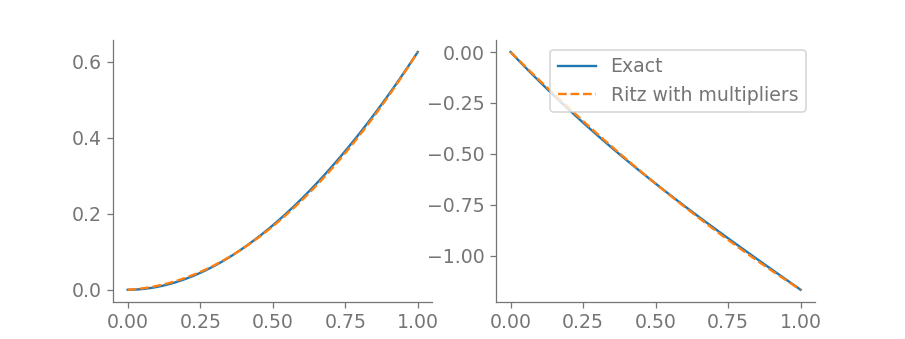

<IPython.core.display.Javascript object>


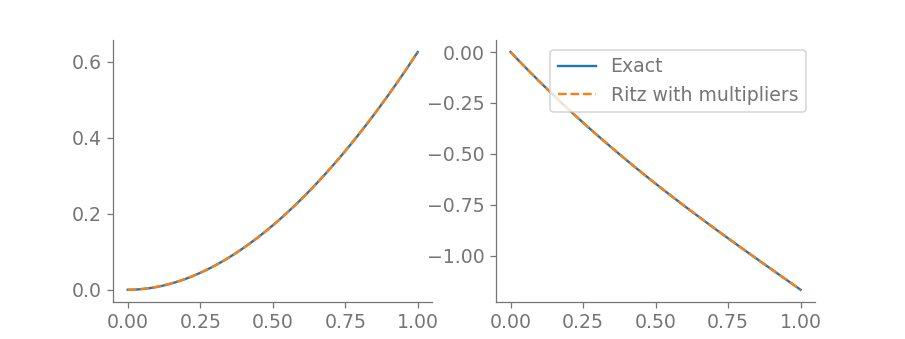

In [11]:
subs = {L: 1, EI:1, M:1, f: 1}
errors_mult = []
for nterms in range(1, 4):
    w, psi, lamda = ritz_multiplier(x, M, EI, f, L, nterms)
    err = (integrate((w - w_exact)**2, (x, 0, L)) +
           integrate((psi - psi_exact)**2, (x, 0, L)) +
           integrate((lamda - lamda_exact)**2, (x, 0, L)))
    norm = (integrate(w_exact**2, (x, 0, L)) +
           integrate(psi_exact**2, (x, 0, L)) +
           integrate(lamda_exact**2, (x, 0, L)))
    errors_mult.append(N(sqrt((err/norm).subs(subs))))
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(121)
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    ax = plt.subplot(122)
    plot_expr(psi_exact.subs(subs), x, ax=ax)
    plot_expr(psi.subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz with multipliers"]);
    
    

In [12]:
errors_mult

# The penalty function formulation

The augmented functional for this formulation is given by

$$P_K (\psi, w) = J(\psi, w) + \frac{K}{2}\int\limits_0^L \left(\psi + \frac{\mathrm{d}w}{\mathrm{d}x}\right)^2\mathrm{d}x\, ,$$

where $K$ is the penalty parameter.


In [13]:
def augmented(x, psi, w, K, M, EI, f, L):
    F = EI/2*diff(psi, x)**2 - f*w
    G = (psi + diff(w, x))
    P = integrate(F, (x, 0, L)) + K/2*integrate(G**2, (x, 0, L)) + M*psi.subs(x, L)
    return P

In [14]:
def ritz_penalty(x, K, M, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    b = symbols("b0:%i"%(nterms))
    var = a + b
    w = sum(a[k]*x**(k + 1) for k in range(nterms))
    psi = sum(b[k]*x**(k + 1) for k in range(nterms))
    M, EI, f, L = symbols("M EI f L")
    P = augmented(x, psi, w, K, M, EI, f, L)
    eqs = [P.diff(C) for C in var]
    sol = solve(eqs, var)
    return w.subs(sol), psi.subs(sol)

<IPython.core.display.Javascript object>


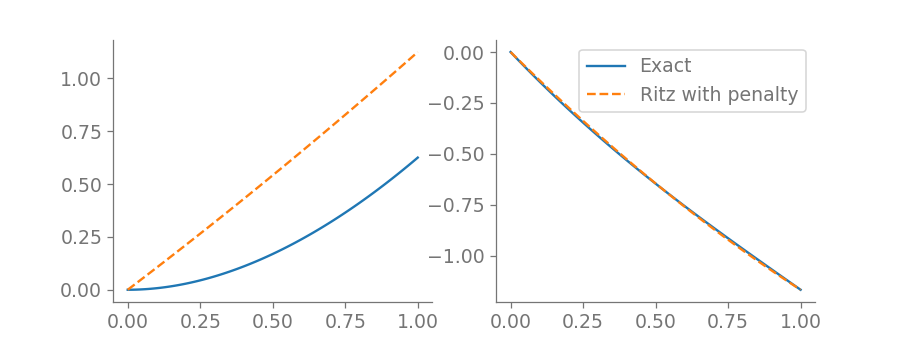

<IPython.core.display.Javascript object>


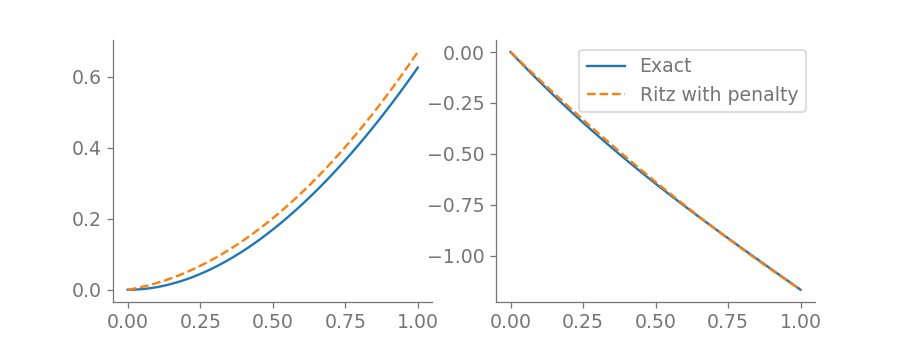

<IPython.core.display.Javascript object>


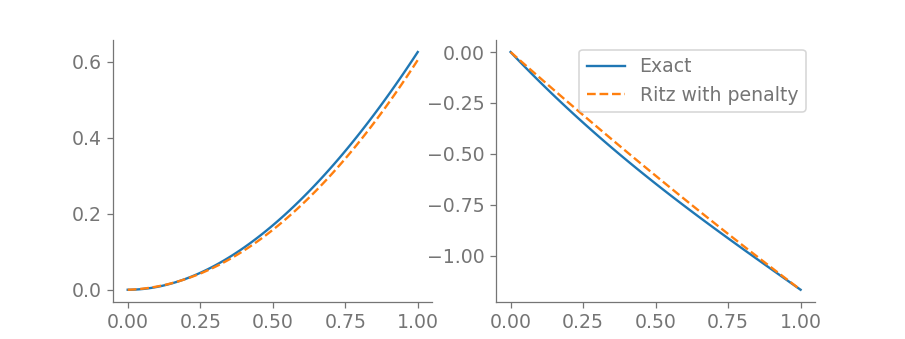

In [15]:
K = symbols("K")
errors_penalty = []
for K_val in [1, 10, 100]:
    subs = {L: 1, EI:1, M:1, f: 1, K: K_val}
    w, psi = ritz_penalty(x, K, M, EI, f, L, 2)
    err = (integrate((w - w_exact)**2, (x, 0, L)) +
           integrate((psi - psi_exact)**2, (x, 0, L)) +
           integrate((lamda - lamda_exact)**2, (x, 0, L)))
    norm = (integrate(w_exact**2, (x, 0, L)) +
           integrate(psi_exact**2, (x, 0, L)) +
           integrate(lamda_exact**2, (x, 0, L)))
    errors_penalty.append(N(sqrt((err/norm).subs(subs))))
    #plt.figure()
    #ax = plt.gca()
    #plot_expr(w_exact.subs(subs), x, ax=ax)
    #plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(121)
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    ax = plt.subplot(122)
    plot_expr(psi_exact.subs(subs), x, ax=ax)
    plot_expr(psi.subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz with penalty"]);

In [16]:
errors_penalty

## Mixed formulation

The mixed formulation involves rewriting a given higher order equation as a pair of llower
order equations by introducing secondary dependent variables. The original equation can be
decomposed into

$$
\frac{M(x)}{EI} = \frac{\mathrm{d}^2 w}{\mathrm{d}x^2}\, ,\quad
\frac{\mathrm{d}^2M(x)}{\mathrm{d}x^2} = f\, ,\quad 0<x<L\, .
$$

The functional in this case is

$$
I(w, M) = \int\limits_0^L\left(\frac{\mathrm{d}w}{\mathrm{d}x}\frac{\mathrm{d}M}{\mathrm{d}x}
+ \frac{M^2}{2EI}+ fw\right)\mathrm{d}x
$$

In [17]:
def mixed_fun(x, w, M, EI, f, L):
    F = diff(w, x)*diff(M, x) + M**2/(2*EI) + f*w
    L = integrate(F, (x, 0, L))
    return L
    

In [18]:
def ritz_mixed(x, Mb, EI, f, L, nterms):
    a = symbols("a0:%i"%(nterms))
    b = symbols("b0:%i"%(nterms))
    var = a + b
    w = sum(a[k]*x**(k + 1) for k in range(nterms))
    M = Mb + sum(b[k]*(x - L)**(k + 1) for k in range(nterms))
    EI, f, L = symbols("EI f L")
    L = mixed_fun(x, w, M, EI, f, L)
    eqs = [L.diff(C) for C in var]
    sol = solve(eqs, var)
    return w.subs(sol), M.subs(sol)

<IPython.core.display.Javascript object>


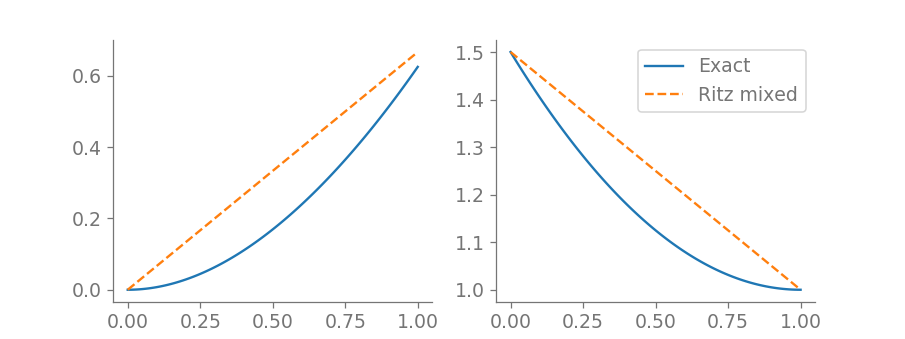

<IPython.core.display.Javascript object>


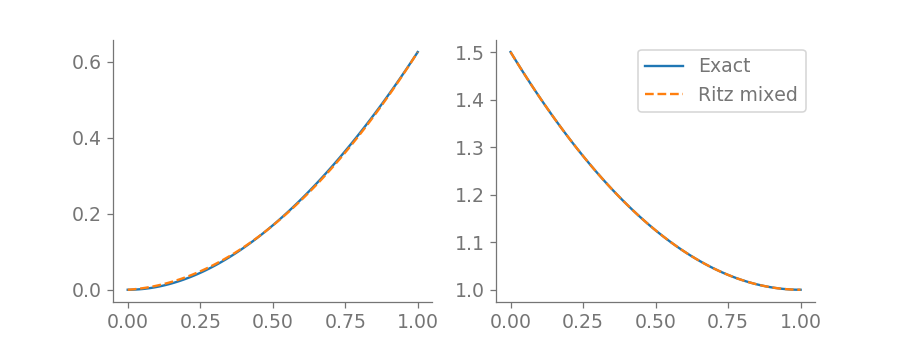

<IPython.core.display.Javascript object>


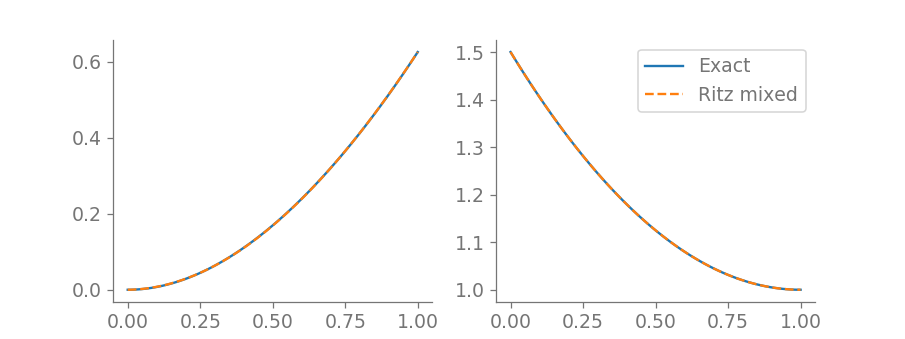

<IPython.core.display.Javascript object>


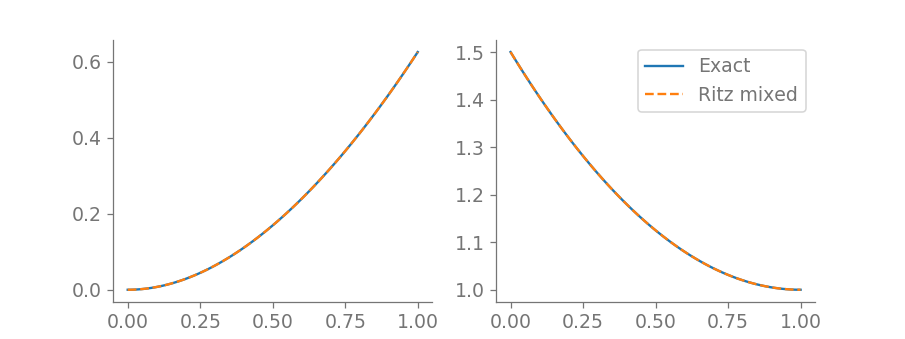

In [19]:
subs = {L: 1, EI:1, f: 1, M:1, Mb:1}
Mb = 1
errors_mix = []
for nterms in range(1, 5):
    w, Ms = ritz_mixed(x, Mb, EI, f, L, nterms)
    err = integrate((w - w_exact)**2, (x, 0, L))
    norm = integrate(w_exact**2, (x, 0, L))
    errors_mix.append(N(sqrt((err/norm).subs(subs))))
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(121)
    plot_expr(w_exact.subs(subs), x, ax=ax)
    plot_expr(w.subs(subs), x, ax=ax, linestyle="dashed")
    ax = plt.subplot(122)
    plot_expr(M_exact.subs(subs), x, ax=ax)
    plot_expr(Ms.subs(subs), x, ax=ax, linestyle="dashed")
    plt.legend(["Exact", "Ritz mixed"]);